In [1]:
import pandas as pd
import numpy as np
import mne
import glob

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [18]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

Load the files, get the points and the list of labels

In [2]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(files) #First 500 by default

In [5]:
print("Num points:", len(all_points))
print("Num labels:", len(all_labels))
print("Labels:", all_labels)

Num points: 374
Num labels: 10
Labels: ['5', '8', '2', '9', '6', '4', '3', '7', '0', '1']


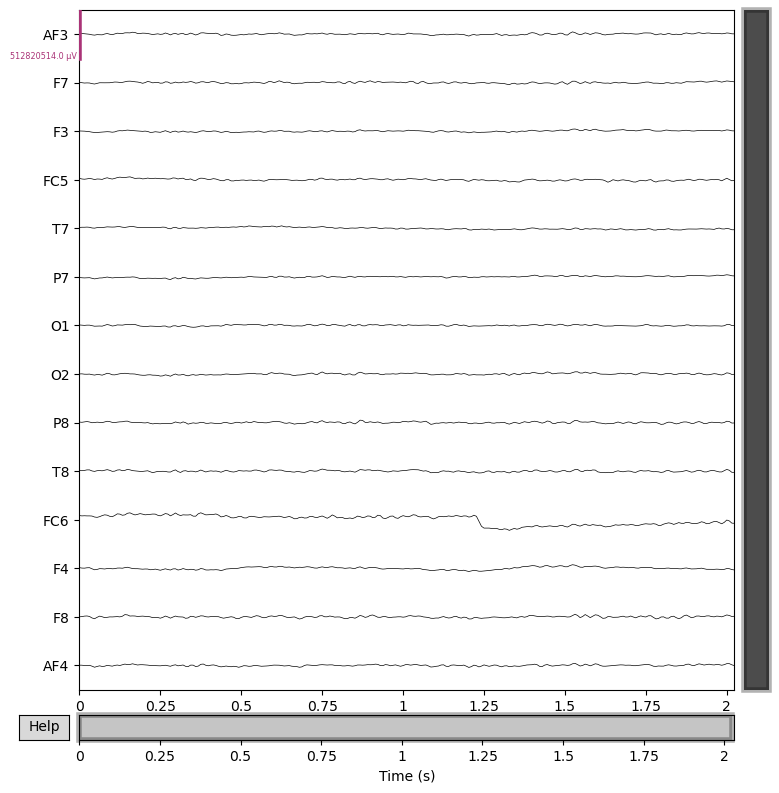

8


In [48]:
all_points[274].mne_object.plot(scalings = 'auto');

The data needs to be filtered for low-frequency and high-frequency signal, which is often resultant from environmental/muscle noise in scalp EEG and otherwise is not generally the focus of analyses. Low-pass and high-pass filtering allows for noise below and above a certain frequency to remain in the data. 

This can done using the MNE command raw.filter( ), and you must specify what you want your band cut-offs to be. Typically, and depending on your planned analyses, filtering will be set around 1 and 50 Hertz. 3-30 BECAUSE WE CARE ABOUT THETA, BETA, ALPHA BANDS. THESE FALL IN THE RANGE OF 3-30 HZ

Bandpass filtering will also have the effect of smoothing out the raw data, and typically looks different than raw data to the naked eye.


The recommendation for setting the low-pass corner frequency at 1/3x
 
 of the desired sample rate is a fairly safe rule of thumb based on the default settings in raw.filter() (which are different from the filter settings used inside the raw.resample() method). If you use a customized lowpass filter (specifically, if your transition bandwidth is wider than 0.5× the lowpass cutoff), downsampling to 3× the lowpass cutoff may still not be enough to avoid aliasing, and MNE-Python will not warn you about it (because the raw.info object only keeps track of the lowpass cutoff, not the transition bandwidth). 

In [7]:
"""
We will loop through every data point and call the cleaning method.
"""
for point in all_points:
    point.clean(1, 30)    #We want 3-30 so multiply 3 by 1/3

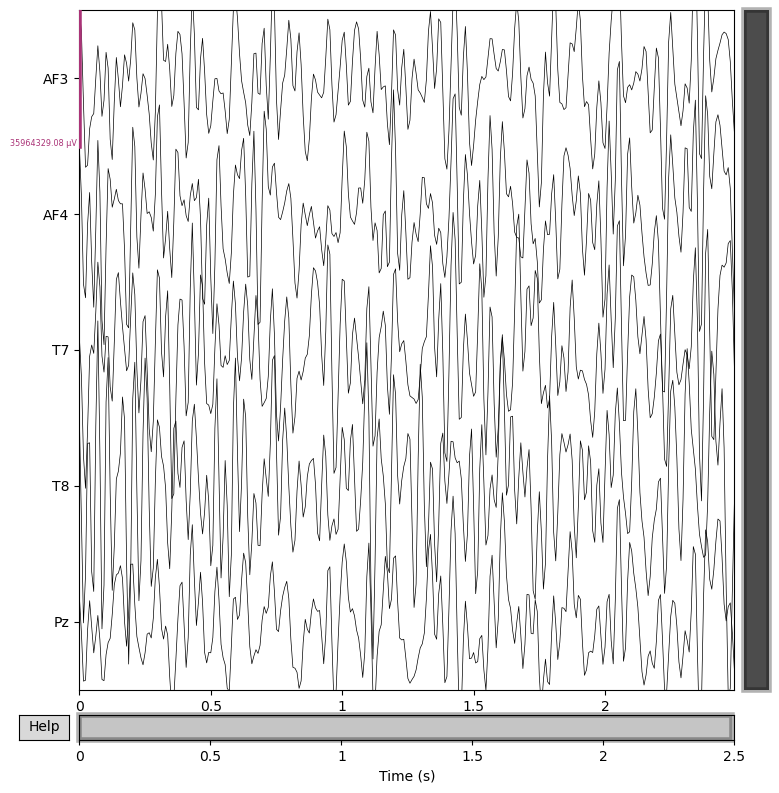

In [8]:
#Quick visual representation of the time series
all_points[0].mne_object.plot(scalings='auto');

Training moment

In [9]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from Old.EegClassifier import EegClassifierModel
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

In [10]:
print(len(all_labels))
num_features = len(all_labels)

569


In [11]:
#Build the dataset. When we ask for an element we wil recieve raw data and also tensor of expected output
dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True) #Split ohbjects

Now, we setup dataloaders and build the model

In [12]:
batch_size = 16

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

model = EegClassifierModel(
    num_classes=num_features, 
    num_channels=5,
    timesteps=320, 
    hidden_size=4000, 
)

In [13]:
from tqdm.notebook import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)
print("If device is cuda, ensure that you set model.device")

n_epoch = 20
final_accuracy = 0.0

assert(batch_size < len(train))  #Check so that if working on subset of data, we don't break

model.to(device=device)
model.device = device            #If not set, everything will be on cpu

optomizer = Adam(model.parameters(), lr=0.001)
loss_function=nn.CrossEntropyLoss()

for epoch in range(n_epoch):

    print(f"Epoch {epoch+1}/{n_epoch}")

    model.train()

    train_accuracy = 0.0
    train_loss = 0.0

    for eegs, labels in tqdm(train_dataloader):
        
        eegs = eegs.to(device)
        labels = labels.to(device)
        optomizer.zero_grad()

        output=model(eegs)
        loss = loss_function(output, labels.squeeze(2))
        loss.backward()
        optomizer.step()

        train_loss += loss.cpu().data*eegs.size(0)
        _, prediction = torch.max(output.data, 1)

        train_accuracy += int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/len(train)
    train_loss=train_loss/len(train)
    
    print("Epoch Accuracy:", train_accuracy)
    print("Epoch Loss:", train_loss, '\n')

print("Final Accuracy:", final_accuracy)


Running on: cpu
If device is cuda, ensure that you set model.device
Epoch 1/20


  0%|          | 0/671 [00:00<?, ?it/s]